# Stroke Classfier
> - Gabrile Serafini
> - Marco Sousa-Poza

This Notebook discribes the computations made to find an optimal stroke classifier based on real healthcare data.

## Exploring the Data
In the following the data will be read and prepared for further use.

In [275]:
# All the necessary imports
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
%matplotlib inline

mpl.rcParams['figure.dpi'] = 100

In [276]:
# Reading the data into a data frame
df_health = pd.read_csv('data/healthcare-dataset-stroke-data.csv')
df_health.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


We see that the data contains some NaN values. If there are not too many we can delete them.

In [277]:
print("The number of NaN values for each column is:")
print(df_health.isna().sum())
print("There are {} rows in this df.".format(df_health.shape[0]))

The number of NaN values for each column is:
id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64
There are 5110 rows in this df.


We rename the binary attributes to something more meaningfull

In [278]:
# Change binary to 'Yes' 'No'
bin_dict = {0:'No',1:'Yes'}
df_health = df_health.replace({
    'hypertension':bin_dict,
    'heart_disease':bin_dict,
    'stroke':bin_dict
})
df_health.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,No,Yes,Yes,Private,Urban,228.69,36.6,formerly smoked,Yes
1,51676,Female,61.0,No,No,Yes,Self-employed,Rural,202.21,NaN,never smoked,Yes
2,31112,Male,80.0,No,Yes,Yes,Private,Rural,105.92,32.5,never smoked,Yes
3,60182,Female,49.0,No,No,Yes,Private,Urban,171.23,34.4,smokes,Yes
4,1665,Female,79.0,Yes,No,Yes,Self-employed,Rural,174.12,24.0,never smoked,Yes


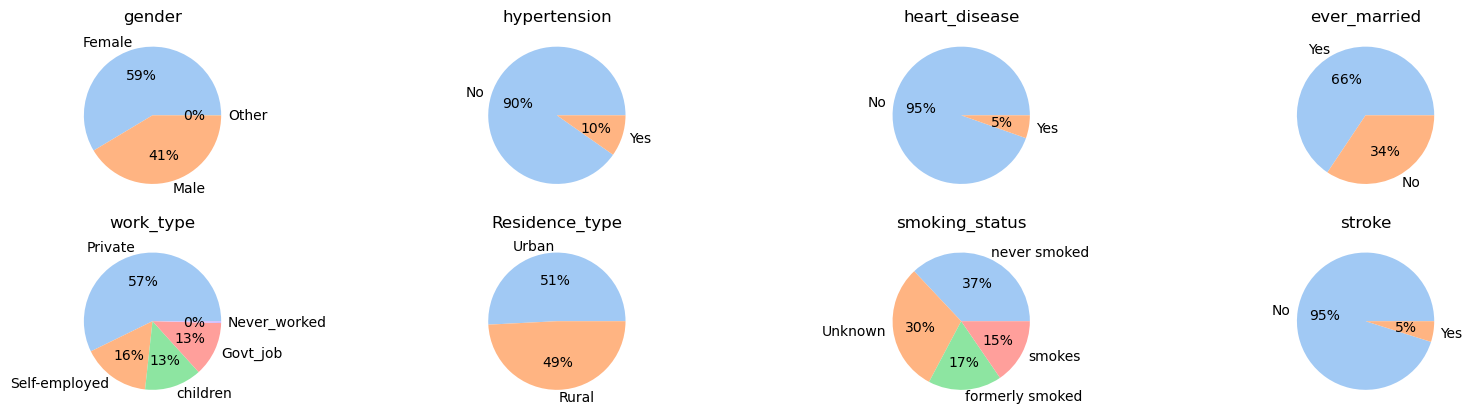

In [279]:
columns = df_health.select_dtypes(include=['object']).columns
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(20,5), facecolor=(1, 1, 1))
for i, col in enumerate(columns):
    ax[i//4, i%4].set_title(col)
    labels = df_health[col].value_counts().index.to_numpy()
    vals = df_health[col].value_counts().values
    colors = sns.color_palette('pastel', n_colors=labels.shape[0])
    ax[i//4, i%4].pie(vals, labels = labels, colors = colors, autopct='%.0f%%')
plt.savefig('nom_attr_dist.png')
plt.show()

## Clean Data

We saw earlier that there are some many `Nan` values in the bmi column. Therefore we will atempt to mean those values based on the gender and the age group.

In [280]:
# We do not need the id
df_health.drop('id', axis=1, inplace=True)
# We remove instances that occure to few times
df_health.drop(df_health[(df_health['gender'] == 'Other')].index, inplace=True)

df_mean = df_health.groupby(['gender', pd.cut(df_health['age'], np.arange(0, 100, 10))]).mean()
df_mean.drop(['age','avg_glucose_level'], axis=1, inplace=True)
df_mean.reset_index(inplace=True)
df_mean.rename({'bmi':'avg_bmi', 'age':'age_group'}, axis=1, inplace=True)
df_health['age_group'] = pd.cut(df_health['age'], np.arange(0, 100, 10))
df_map = df_health.merge(df_mean, on=('gender', 'age_group'), how='inner')['avg_bmi']
df_health['bmi'] = df_health['bmi'].fillna(df_map)
df_health.drop('age_group', axis=1, inplace=True)

# never_worked also occures to few times
df_health.drop(df_health[df_health['work_type'] == 'Never_worked'].index, inplace=True)

print('We now have {} remaining nan values!'.format(df_health['bmi'].isna().sum()))

We now have 0 remaining nan values!


Next we have to look for any outliers:

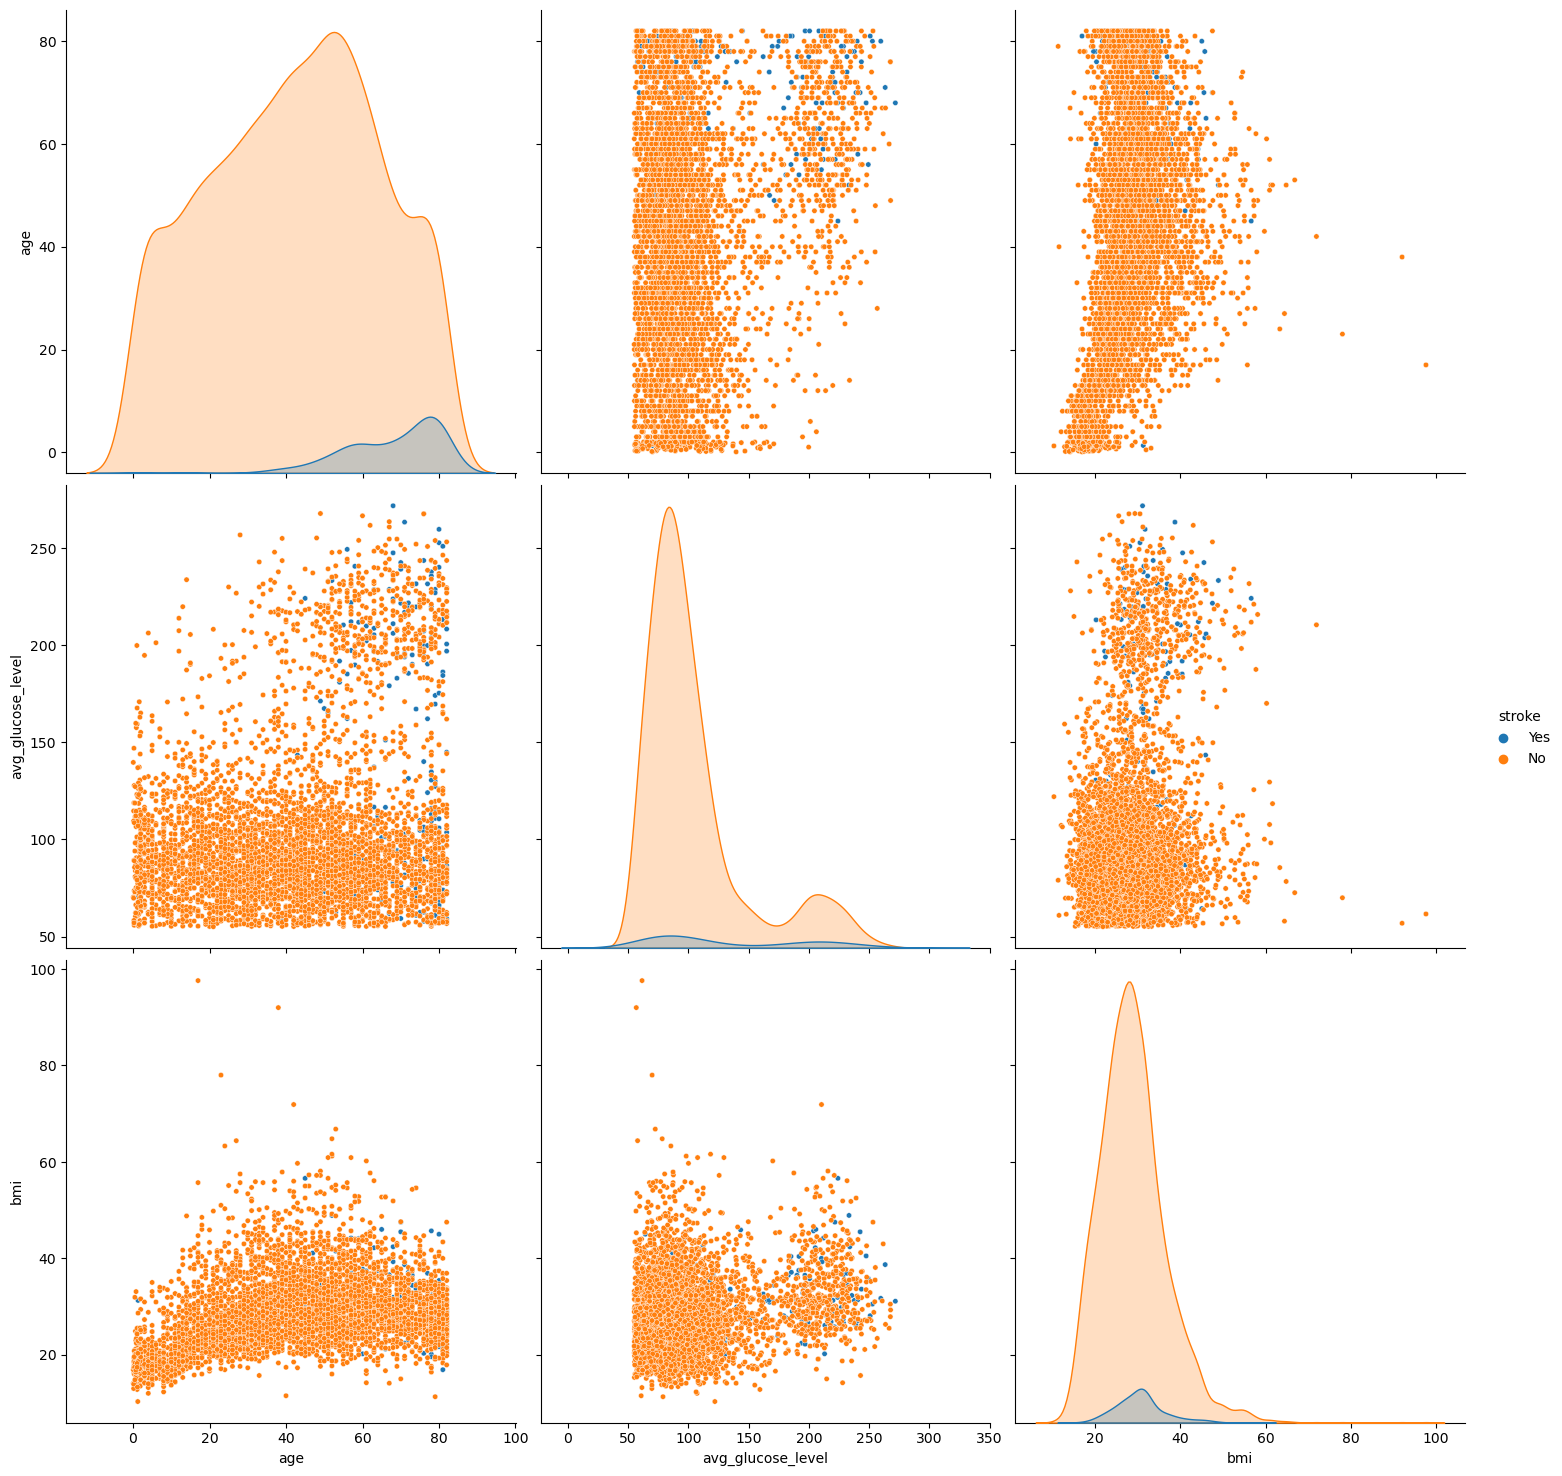

In [281]:
ax = sns.pairplot(df_health['age avg_glucose_level bmi stroke'.split()], hue='stroke', height=5, plot_kws={"s": 15})
plt.show()

There are some bmi values that are too high:

In [282]:
df_health = df_health[df_health['bmi'] <= 70]

Next we change the nominal attributes to numerical ones. This is important for the numerical classifiers.

In [283]:
gender_dict = {'Female':1, 'Male':0}
bin_dict = {'Yes':1, 'No':0}
worktype_dict = {'Private':3, 'Self-employed':2, 'children':1, 'Govt_job':0}
residence_dict = {'Urban':1, 'Rural':0}
smoke_dict = {'never smoked':1,'formerly smoked':2,'smokes':3, 'Unknown':4}
health_numerical = df_health.replace({
    'gender' : gender_dict,
    'ever_married' :bin_dict,
    'work_type' : worktype_dict,
    'Residence_type' : residence_dict,
    'smoking_status' : smoke_dict,
    'hypertension' : bin_dict,
    'heart_disease' : bin_dict,
    'stroke' : bin_dict 
})

In [284]:
health_np = health_numerical.values

Let also standardize the data to get rid of any scalars

In [285]:
y = health_np[:,-1]
columns = list(health_numerical.columns[:-1])
target = health_numerical.columns[-1]
X = health_np[:, :-1]

## Data Vizualisation

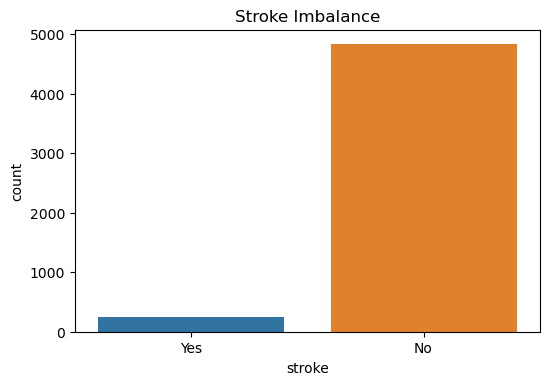

In [286]:
plt.title('Stroke Imbalance')
sns.countplot(x='stroke', data=df_health)
# plt.savefig(dpi=400, fname='img.png')
plt.show()

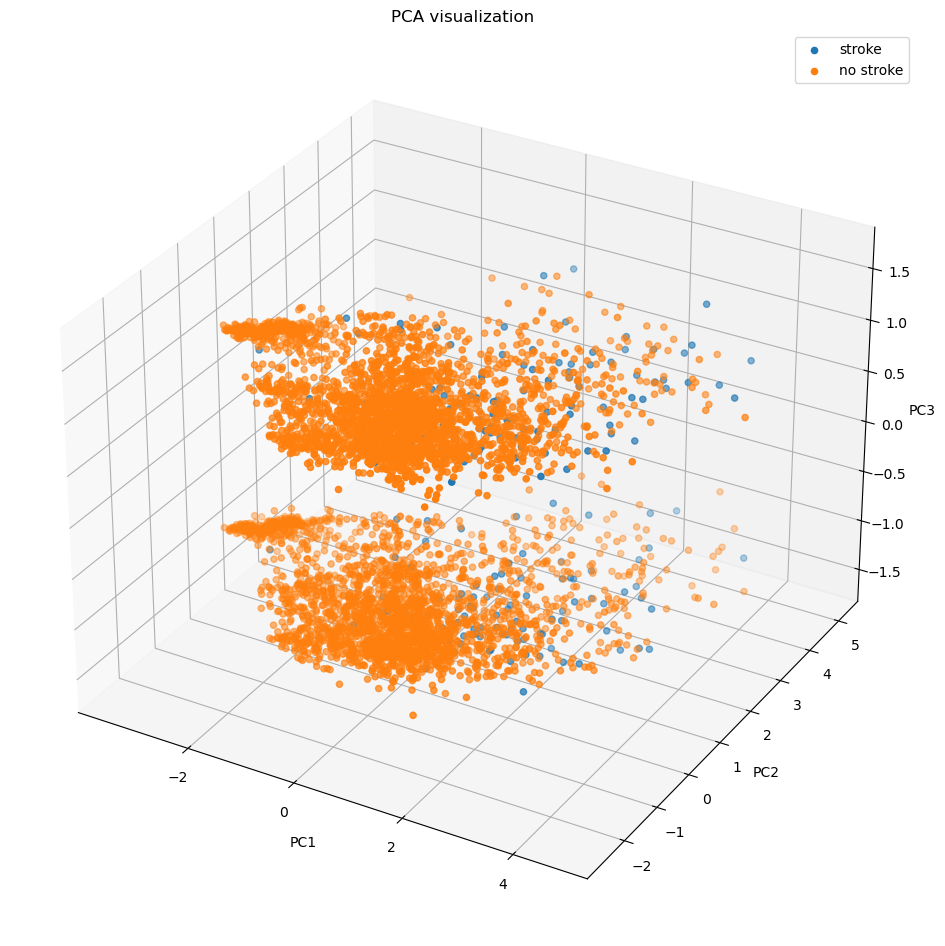

In [287]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
stc = StandardScaler()
pca = PCA()
p = make_pipeline(stc, pca)
health_pca = p.fit_transform(X)

# Plot PCA
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

ax.scatter(health_pca[y==1][:,0], health_pca[y==1][:,1], health_pca[y==1][:,2], label='stroke')
ax.scatter(health_pca[y==0][:,0], health_pca[y==0][:,1], health_pca[y==0][:,2], label='no stroke')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend()
ax.set_title('PCA visualization')

plt.show()

We can see that the data is not well separated by the PCs. This is a indicator that the data will probably not be that well separated with a linear model. This is something we need to keep in mind when choosing hyperparameters for some of our classifiers.

### Correlations
Let us see if there are any correlations

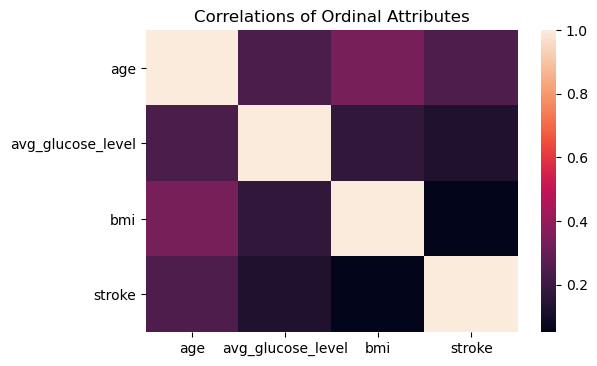

In [288]:
plt.title('Correlations of Ordinal Attributes')
ax = sns.heatmap(health_numerical['age avg_glucose_level bmi stroke'.split()].corr())
plt.show()

## Classification

### Models

In [289]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
kf = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=42)

### Preprocessing

In [290]:
# all our models work better with normalized data
X = sc.fit_transform(X)

### Tree Classifier

Finding the right hyper-parameters for our tree:

In [291]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier
from itertools import product

min_splits = [n for n in range(40, 60, 4)]
max_depths = [n for n in range(10,20,1)]

avg_scores = pd.DataFrame(columns='fit_time score_time test_f1 test_recall test_accuracy test_roc_auc min_splits max_depth'.split())
for min_split, max_depth in product(min_splits, max_depths):
    model = DecisionTreeClassifier(
        criterion='gini', 
        max_depth=max_depth, 
        min_samples_split=min_split,
        class_weight='balanced'
    )
    scores = pd.DataFrame(cross_validate(model, X, y, scoring=('recall', 'accuracy', 'roc_auc', 'f1'), cv=kf, n_jobs=-1)).mean()
    scores['min_splits'], scores['max_depth'] = min_split, max_depth
    avg_scores = avg_scores.append(scores[avg_scores.columns], ignore_index=True)

avg_scores.drop('fit_time score_time'.split(), axis=1, inplace=True)
avg_scores.sort_values(by='test_f1 test_recall test_accuracy test_roc_auc'.split(), ascending=False).head(10)

,test_f1,test_recall,test_accuracy,test_roc_auc,min_splits,max_depth
1,0.215291,0.571767,0.794885,0.712466,40.0,11.0
12,0.214505,0.579800,0.791266,0.720796,44.0,12.0
11,0.214385,0.583800,0.789612,0.722218,44.0,11.0
21,0.213616,0.588533,0.787094,0.726412,48.0,11.0
2,0.213456,0.561367,0.796579,0.707943,40.0,12.0
20,0.213366,0.605367,0.780329,0.732306,48.0,10.0
22,0.213359,0.584533,0.788198,0.724628,48.0,12.0
0,0.213264,0.590167,0.785719,0.719907,40.0,10.0
10,0.213181,0.600633,0.781862,0.727913,44.0,10.0
41,0.212723,0.601333,0.781155,0.732048,56.0,11.0


We will now take the best performing forrest:

In [292]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)

clf = DecisionTreeClassifier(criterion='gini', max_depth=12, min_samples_split=56, class_weight='balanced')
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=12,
                       min_samples_split=56, random_state=42)

To see how well the model performed the confuxion matrix of the best performing tree is shown:

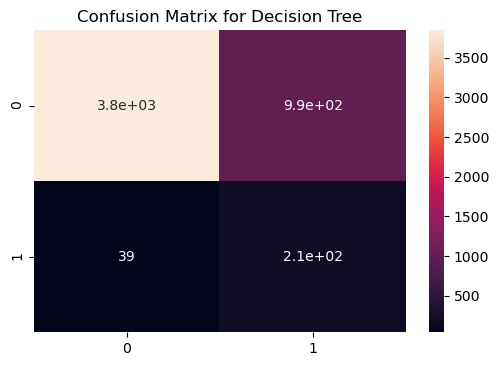

In [293]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y, clf.predict(X))
sns.heatmap(cm, annot=True)
plt.title('Confusion Matrix for Decision Tree')
plt.show()

Since the tree it not that large, we can also vizualize it:

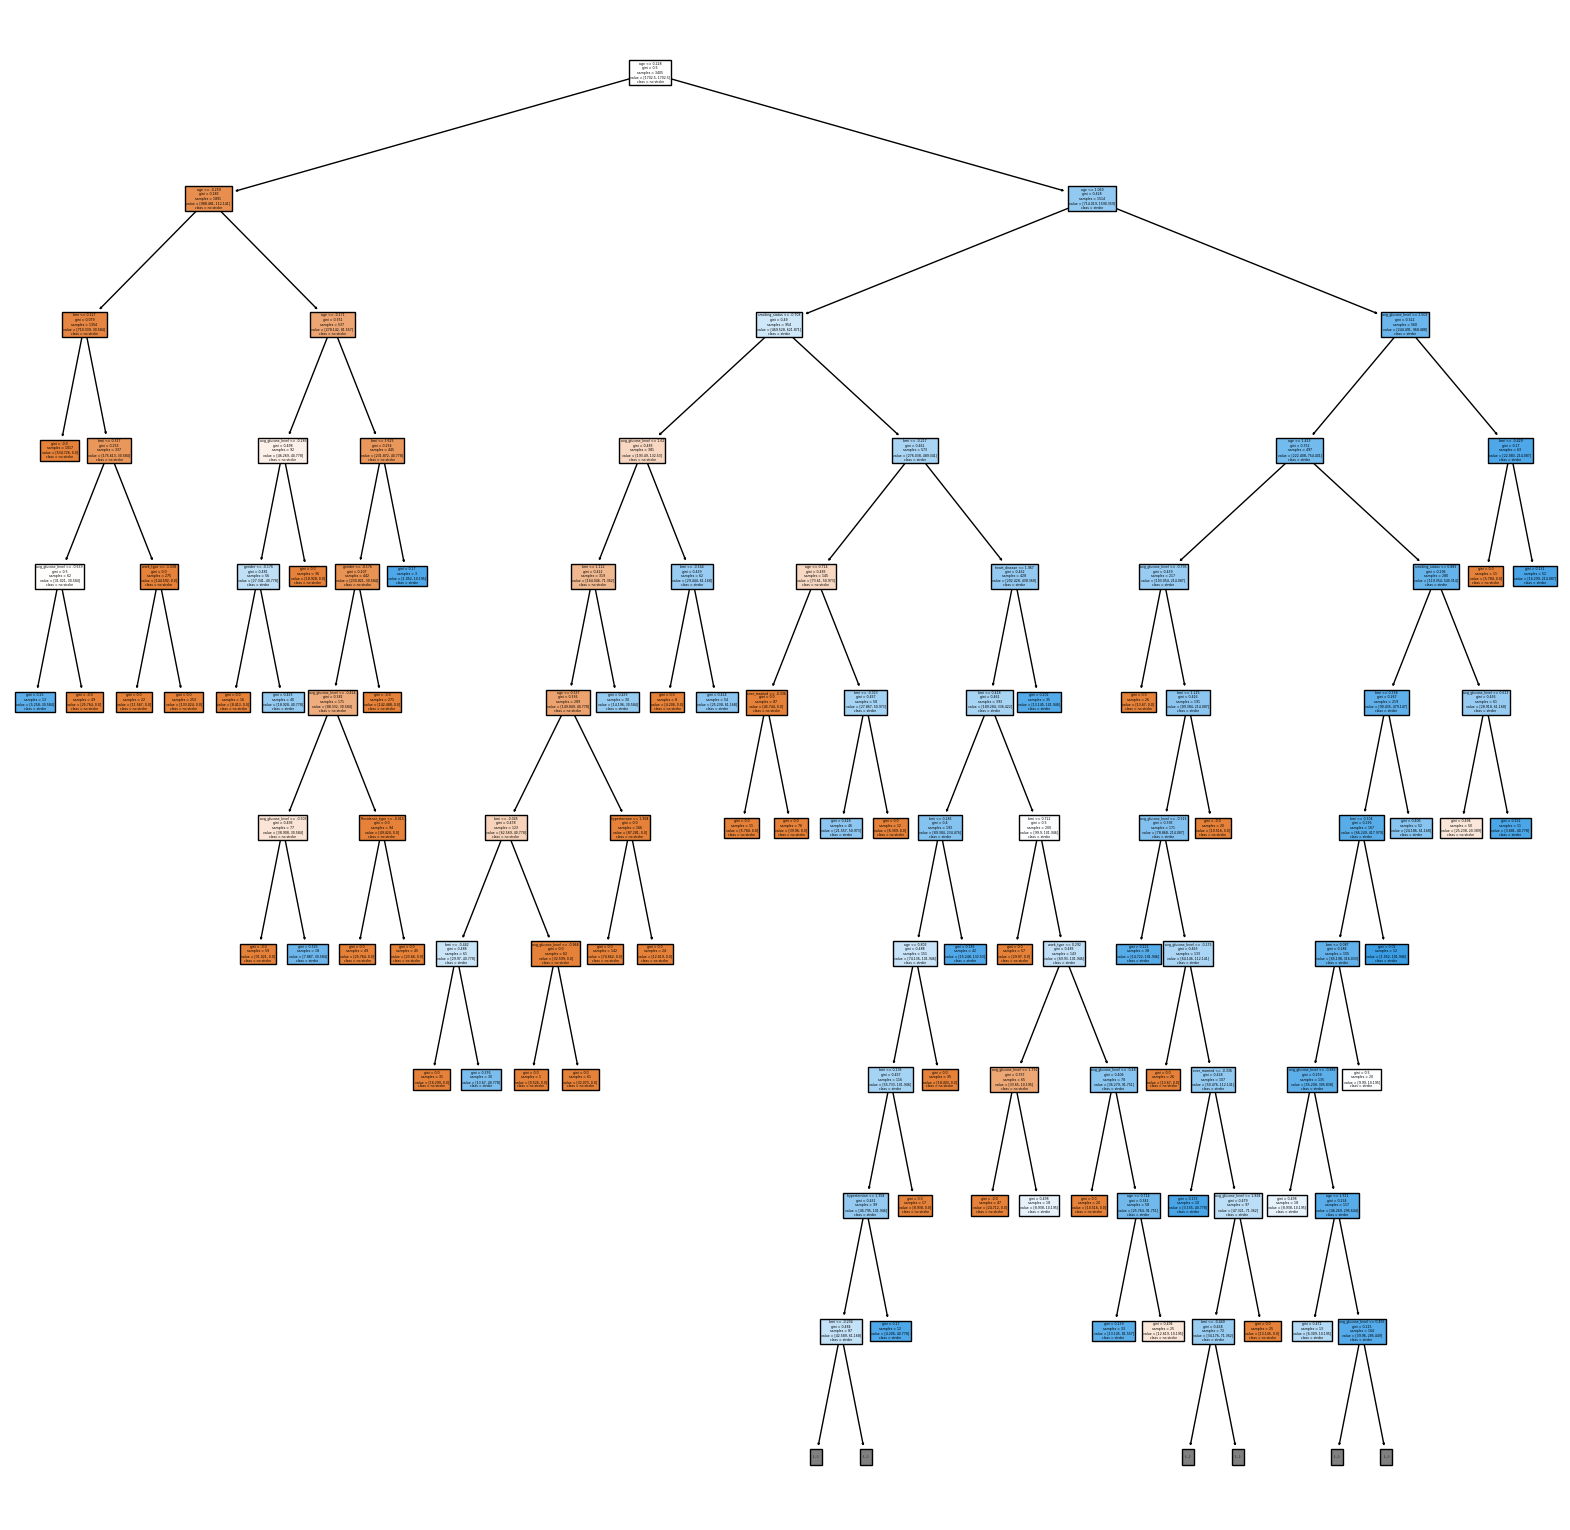

In [294]:
from sklearn.tree import plot_tree

fig = plt.figure(figsize=(20,20))
plt.title('Decision Tree Vizualisation')
ax = plot_tree(clf, 
             feature_names=columns,  
             class_names=['no stroke', 'stroke'],
             max_depth=10,
             filled=True)
plt.show()

fit_time         0.009621
score_time       0.006428
test_recall      0.385333
test_accuracy    0.864375
dtype: float64


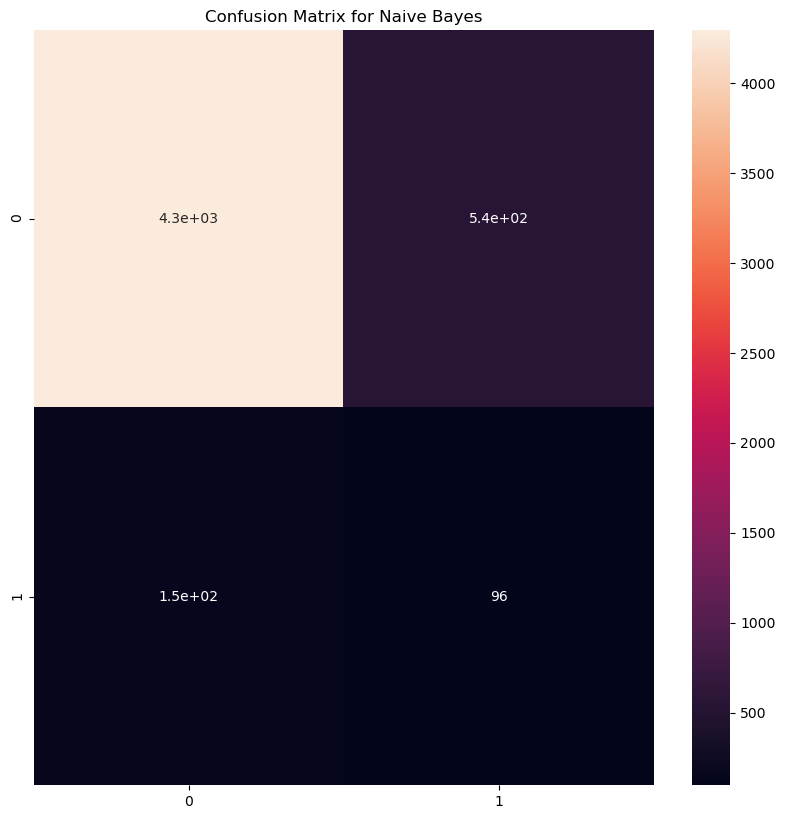

In [295]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
import seaborn as sns
from itertools import product

model = GaussianNB()
scores = pd.DataFrame(cross_validate(model, X, y, scoring='recall accuracy'.split(), cv=kf, n_jobs=-1, return_estimator=True))
print(scores.mean())


# make a test with confusion matrix
model.fit(X, y)
cm = confusion_matrix(y, model.predict(X))
fig = plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True)
plt.title('Confusion Matrix for Naive Bayes')
plt.show()

### Support Vector Machine

In [296]:
from sklearn.svm import SVC

kernels = ['poly', 'rbf', 'sigmoid']
degrees = [x for x in range(1, 4, 1)] #increase domain if you want to verify that indeed sigmoid is the best
hypers = [(x, y) for x in kernels for y in degrees if x == 'poly' or y == degrees[0]]

avg_scores = pd.DataFrame(columns='fit_time score_time test_recall test_accuracy test_roc_auc kernel degree'.split())
for kernel, degree in hypers:
    model = SVC(kernel=kernel, degree=degree, class_weight='balanced')
    scores = pd.DataFrame(cross_validate(model, X, y, scoring='recall accuracy roc_auc'.split(), cv=kf, n_jobs=-1)).mean()
    scores['kernel'], scores['degree'] = kernel, degree
    avg_scores = avg_scores.append(scores[avg_scores.columns], ignore_index=True)
avg_scores.drop('fit_time score_time'.split(), axis=1, inplace=True)
avg_scores.sort_values(by='test_recall test_accuracy test_roc_auc'.split(), ascending=False).head(10)

,test_recall,test_accuracy,test_roc_auc,kernel,degree
0,0.826500,0.722531,0.840319,poly,1
1,0.721200,0.763490,0.798824,poly,2
4,0.716333,0.679047,0.727125,sigmoid,1
3,0.671233,0.755936,0.794156,rbf,1
2,0.624600,0.778913,0.766826,poly,3


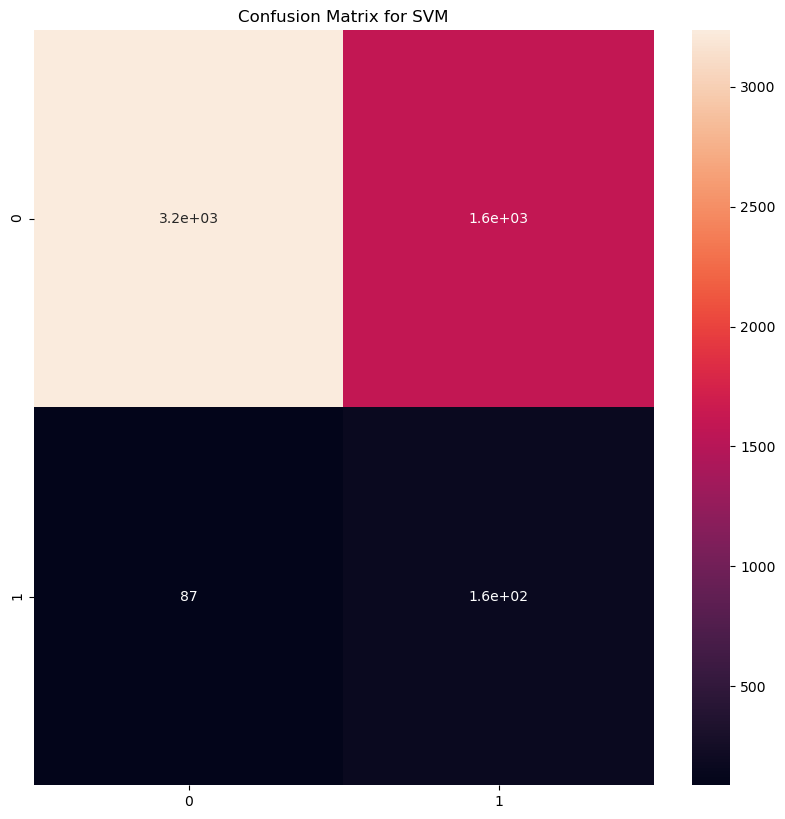

In [297]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)

svm = SVC(kernel='sigmoid', class_weight='balanced')
svm.fit(X_train, y_train)
cm = confusion_matrix(y, svm.predict(X))
fig = plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True)
plt.title('Confusion Matrix for SVM')
plt.show()

### Logistig Regression

In [298]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(class_weight='balanced')
scores = pd.DataFrame(cross_validate(model, X, y, scoring='recall accuracy roc_auc'.split(), cv=kf, n_jobs=-1)).mean()
scores

fit_time         0.034534
score_time       0.009028
test_recall      0.808767
test_accuracy    0.734571
test_roc_auc     0.840159
dtype: float64

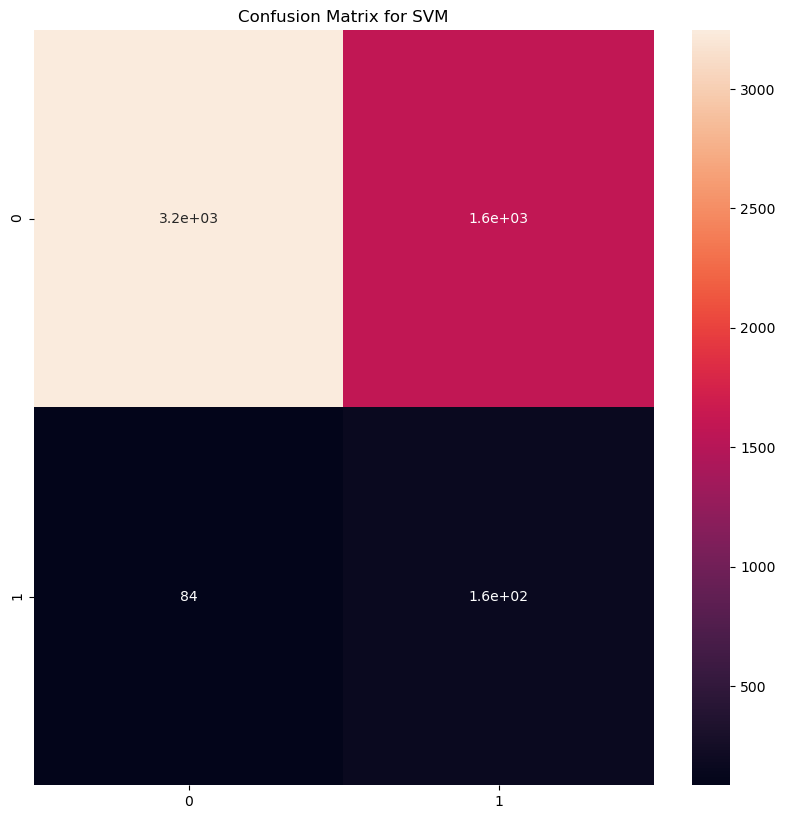

In [299]:
lr = SVC(kernel='sigmoid', class_weight='balanced')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
lr.fit(X_train, y_train)
cm = confusion_matrix(y, lr.predict(X))
fig = plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True)
plt.title('Confusion Matrix for SVM')
plt.show()